In [1]:
# Base utilities
import os

# Data Mining
import math
import random
random_state = 42
random.seed(random_state)
seed=random_state
import numpy as np
import pandas as pd
import geopandas as gpd
# import osmnx as ox
# import pandana as pdn
import pickle as pkl
import folium

# Plot
import matplotlib.pyplot as plt
import matplotlib.pyplot as plot
import seaborn as sns

# Learning
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, train_test_split, KFold

# Models
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Directories
for d in ["data", "models", "logs", "results"]:
    if not os.path.isdir(d):
        os.mkdir(d)

In [4]:
# Read
trips = pd.read_csv(f"results/trips_pre_model.csv",index_col=0)
# trips = pd.read_csv('/content/drive/MyDrive/Mobility_Choice/model/results/trips_pre_model.csv',index_col=0)
trips

,Modo,Hora_Ini_E,Dur_Tot,Per_hog,Turismos,Sexo,Edad,crnt_tur,Group,O_lat,...,30%,drive_tt,distance,walk_tt,transit_tt,transit_tt_gm,gm_ua,Tipo_familia,Mun_Ori,Mun_Des
0,Car,109,13.9,2,2,1,6,1,2194,43.315076,...,1,14.314333,7713.093,93.942367,36.442,60.0,0.488542,4,69,69
1,Car,62,15.1,2,2,1,4,1,1651,43.317024,...,1,12.797800,8962.584,145.466050,46.524,51.0,0.091793,2,69,69
2,PT,180,36.1,2,4,2,3,1,2731,43.324474,...,1,10.141033,6449.426,94.093417,30.343,36.0,0.170538,2,69,69
3,Car,198,17.5,3,2,1,5,1,1710,43.323712,...,1,13.098367,6794.456,84.678717,38.993,78.0,0.666826,2,69,69
4,PT,106,10.7,2,1,1,5,1,1646,43.311060,...,1,1.725333,768.076,12.326833,9.184,11.0,0.179945,2,69,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10313,Andando,83,15.4,2,1,1,4,2,347,43.305996,...,1,2.604183,1240.299,15.294017,7.962,18.0,0.773284,2,56,56
10314,Andando,100,5.3,1,2,2,4,1,358,43.307498,...,1,1.201000,495.243,5.661667,4.208,6.0,0.351097,3,56,56
10315,Andando,159,5.0,2,2,2,5,1,359,43.306916,...,1,0.691717,291.519,4.914900,3.656,6.0,0.485501,3,56,56
10316,Andando,93,14.3,1,1,1,2,2,347,43.307285,...,1,1.938700,862.164,14.051100,10.263,18.0,0.547500,2,56,56


# Cross validation

In [63]:
from sklearn.model_selection import GroupKFold

from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Definir los modelos base
rf_clf = RandomForestClassifier(n_estimators=20, random_state=42)
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation='relu', solver='adam', random_state=42)
svm_clf = SVC(probability=True, random_state=1)

# Para VotingClassifier
voting_clf = VotingClassifier(estimators=[('rf', rf_clf), ('mlp', mlp_clf), ('svm', svm_clf)], voting='hard')

# O para StackingClassifier
stacking_clf = StackingClassifier(estimators=[('rf', rf_clf), ('mlp', mlp_clf)],
                                  final_estimator=LogisticRegression())

# Definir el método de división de datos teniendo en cuenta los grupos
group_kfold = GroupKFold(n_splits=5)

# Puedes elegir entre voting_clf y stacking_clf dependiendo de tu preferencia
model = rf_clf  # o stacking_clf



# model = RandomForestClassifier(n_estimators=20,random_state=random_state)
model_name = type(model).__name__
k=10
gkf = GroupKFold(n_splits=k)

print(model_name,"\n")
print(f"{k}-FOLD CV\n")
# k fold cross validation

df = df_4

cv_scores = cross_val_score(model, df.drop(columns=["Modo", "Group"]), np.array(df["Modo"]), cv=gkf, groups = np.array(df["Group"]), n_jobs=-1)

# Scores on k-fold CV
# Imprimir el score de cada ronda
for i,score in zip(range(1,k+1),cv_scores):
    print(f"Round {i} score: {score}")
print("")

ax = sns.barplot(x = np.arange(1,k+1), y = np.array(cv_scores))
ax.set(xlabel='Round', ylabel='Accuracy',title=f"{k}-fold CV Accuracy plot")
plt.show()

# scores avg on k-fold CV
print(f"Score avg on {k}-fold CV: {cv_scores.mean()}\n")

#pickle
with open(os.path.join("models",f'{model_name}.pkl'), 'wb') as file:
    pkl.dump(model, file)

VotingClassifier 

10-FOLD CV



# Train-test with GroupkFold

In [93]:
# Min sampling

green = trips[trips['Modo'] != 'Car'].reset_index(drop=True)
car = trips[trips['Modo'] == 'Car'].reset_index(drop=True)

df_shuffled = car.sample(frac=1).reset_index(drop=True)
split_size = len(df_shuffled) // 3

# Split the DataFrame
df1_car = df_shuffled.iloc[:split_size].reset_index(drop=True)
df2_car = df_shuffled.iloc[split_size:2*split_size].reset_index(drop=True)
df3_car = df_shuffled.iloc[2*split_size:3*split_size].reset_index(drop=True)

df1 = pd.concat([green, df1_car], ignore_index=True)
df2 = pd.concat([green, df2_car], ignore_index=True)
df3 = pd.concat([green, df3_car], ignore_index=True)

df1 = df1.sample(frac=1).reset_index(drop=True)
df2 = df2.sample(frac=1).reset_index(drop=True)
df3 = df3.sample(frac=1).reset_index(drop=True)

In [29]:
from sklearn.model_selection import GroupKFold
from sklearn.neural_network import MLPClassifier

# model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation='relu', solver='adam', random_state=random_state)

# class_weights = {
#     'Car': 1,         # The base weight
#     'PT': 6000/1800,  # More weight since it's less frequent
#     'Andando': 6000/2500 # More weight since it's less frequent but more so than 'pt'
# }

# from sklearn.ensemble import GradientBoostingClassifier
# model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=6000)

# model = KNeighborsClassifier(n_neighbors=20)

# model = SVC(kernel='linear', C=1.0, random_state=6000)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(64, activation='relu', input_shape=(11,)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model = RandomForestClassifier(n_estimators=20, random_state=6000, class_weight=class_weights)
# model = RandomForestClassifier(n_estimators=20, random_state=6000)
model_name = type(model).__name__

df = trips

# X = trips.drop(columns=["Modo", "Group", "Mun_Ori", "Mun_Des", "Com_Ori", "Com_Des"])
X = df.drop(columns=["Modo", 'Dur_Tot', "Group", "O_lat", "O_long", "D_lat", "D_long", 'times', 'destination_coords', 'chosen_time', '30%', 'transit_tt', 'gm_ua', "Mun_Ori", "Mun_Des"])
y = np.array(df["Modo"])
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
groups = np.array(df["Group"])

accuracies = []

gkf = GroupKFold(n_splits=10)

for train_index, test_index in gkf.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Store accuracy
    accuracy = model.score(X_test, y_test)
    accuracies.append(accuracy)

    # print("Accuracy: ",model.score(X_test,y_test),"\n")
    # Prediction and Report
    y_pred = model.predict(X_test)
    # print("Classification Report\n")
    # print(metrics.classification_report(y_test, y_pred),"\n")

    # print("Confusion Matrix\n")
    metrics.ConfusionMatrixDisplay.from_predictions(y_test,y_pred,cmap="Reds")
    # models[model_name] = model

# pickle
with open(os.path.join(f"models",'rf.pkl'), 'wb') as file:
    pkl.dump(model, file)

# After all folds are done, plot the accuracies
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), accuracies)
plt.title('Model Accuracies per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(range(1, 11))  # to set the x-ticks for each fold
plt.show()
sum(accuracies) / len(accuracies)

UnimplementedError: Graph execution error:

Detected at node binary_crossentropy/Cast defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\iazka\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\iazka\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1043, in launch_instance

  File "C:\Users\iazka\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "C:\Users\iazka\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 607, in run_forever

  File "c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\iazka\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "C:\Users\iazka\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "C:\Users\iazka\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "C:\Users\iazka\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "C:\Users\iazka\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "C:\Users\iazka\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "C:\Users\iazka\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell

  File "C:\Users\iazka\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell

  File "C:\Users\iazka\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\iazka\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async

  File "C:\Users\iazka\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes

  File "C:\Users\iazka\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code

  File "C:\Users\iazka\AppData\Local\Temp\ipykernel_15344\655132142.py", line 51, in <module>

  File "c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1807, in fit

  File "c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function

  File "c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function

  File "c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step

  File "c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1151, in train_step

  File "c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss

  File "c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__

  File "c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 143, in __call__

  File "c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 270, in call

  File "c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 2521, in binary_crossentropy

Cast string to float is not supported
	 [[{{node binary_crossentropy/Cast}}]] [Op:__inference_train_function_2177]

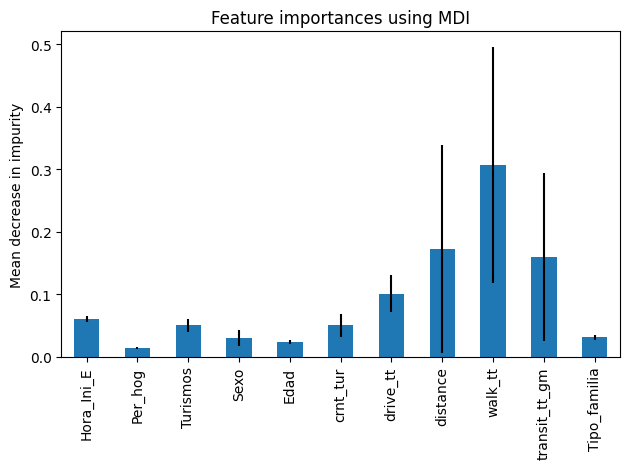

In [7]:
import time
import numpy as np

start_time = time.time()
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
elapsed_time = time.time() - start_time

# print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
import pandas as pd
# forest_importances = pd.Series(importances, index=df_4.drop(columns=['Modo', 'Group']).columns)
columns_to_use = df.drop(columns=["Modo", 'Dur_Tot', "Group", "O_lat", "O_long", "D_lat", "D_long", 'times', 'destination_coords', 'chosen_time', '30%', 'transit_tt', 'gm_ua', "Mun_Ori", "Mun_Des"]).columns
forest_importances = pd.Series(importances, index=columns_to_use)

variables_to_exclude = []

forest_importances = forest_importances.drop(variables_to_exclude)
# filtered_indices = [np.where(columns_to_use == feature)[0][0] for feature in forest_importances.index]

# Now, use these filtered indices to select the matching elements from the std array
# std_filtered = std[filtered_indices]

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()